In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import math
from torch.utils.data import TensorDataset, DataLoader

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [27]:
data = pd.read_csv('/home/aibig25/hong_sj/trb/num.csv')
data = data.fillna(0)

unique_ids = data['sequence_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=41, random_state=42)
train_data = data[data['sequence_ID'].isin(train_ids)]
test_data = data[data['sequence_ID'].isin(test_ids)]

independent_vars = data.columns.difference(['center_x', 'center_y','center_x_ma','center_y_ma', 'ID', 'LC'])
dependent_vars = ['center_y_ma']

scaler = MinMaxScaler()

train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
test_data[independent_vars] = scaler.transform(test_data[independent_vars])

X_train = train_data[independent_vars]
y_train = train_data[dependent_vars]

X_test = test_data[independent_vars]
y_test = test_data[dependent_vars]

/tmp/ipykernel_122552/3224682186.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
/tmp/ipykernel_122552/3224682186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[independent_vars] = scaler.transform(test_data[independent_vars])


In [28]:
# 입력 및 예측 시퀀스 길이 정의
input_sequence_length = 30
output_sequence_length = 30
output_size = 1 

def create_sequences(data, input_sequence_length, output_sequence_length):
    X = []
    y = []

    for i in range(len(data) - input_sequence_length - output_sequence_length + 1):
        X.append(data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        y.append(data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, input_sequence_length, output_sequence_length)
X_test, y_test = create_sequences(test_data, input_sequence_length, output_sequence_length)

In [29]:
# 데이터셋을 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * output_sequence_length)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # GPU를 위한 설정
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # GPU를 위한 설정
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 마지막 시간 단계의 출력만 사용
        out = out.view(-1, output_sequence_length, output_size)  # 출력 형태 조정
        return out

In [34]:
input_size = len(independent_vars)  # 입력 특성 수
hidden_size = 128  # LSTM 은닉 상태의 크기
num_layers = 2  # LSTM 층 수
output_size = 1 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 인스턴스화
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
model = model.float()  # 데이터 타입을 float32로 맞추기

# 손실 함수와 옵티마이저
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

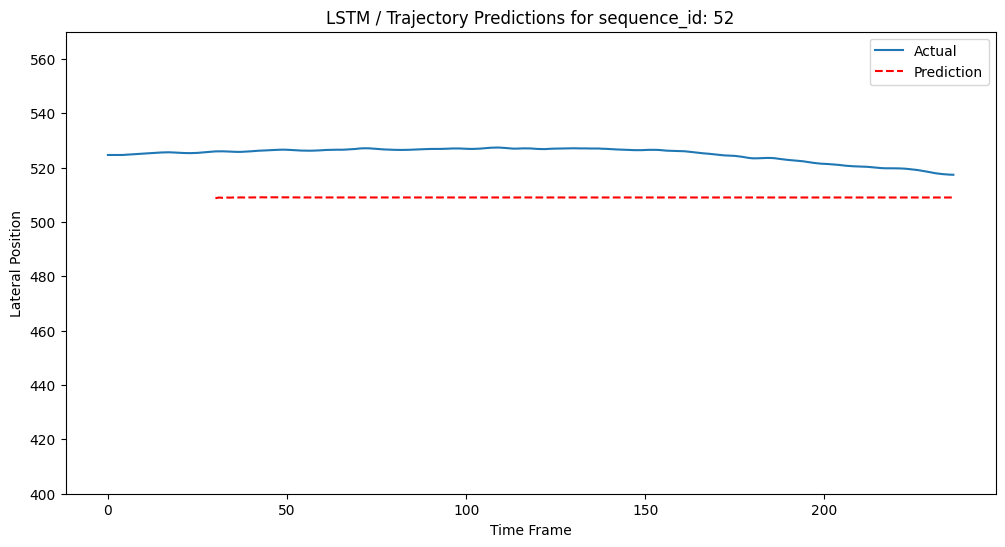

In [42]:
# 차량 ID 및 파라미터 설정
sequence_id = 52

# sequence_ID에 해당하는 데이터 필터링 및 스케일링
vehicle_data = data[data['sequence_ID'] == sequence_id].copy()
vehicle_data[independent_vars] = scaler.transform(vehicle_data[independent_vars])
total_frames = len(vehicle_data)

# input_sequence_length와 output_sequence_length를 적용하여 데이터 전처리
def create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length):
    X = []
    y = []
    
    # 마지막 시퀀스까지 처리할 수 있도록 수정
    for i in range(len(vehicle_data) - input_sequence_length + 1):
        X.append(vehicle_data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        if i + input_sequence_length + output_sequence_length <= len(vehicle_data):
            y.append(vehicle_data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
        else:
            # 마지막 시퀀스가 output_sequence_length보다 짧으면 0으로 패딩
            remaining_length = len(vehicle_data) - (i + input_sequence_length)
            last_sequence = vehicle_data.iloc[(i + input_sequence_length):][dependent_vars].values
            padded_sequence = np.pad(last_sequence, ((0, output_sequence_length - remaining_length), (0, 0)), mode='constant')
            y.append(padded_sequence)
    
    return np.array(X), np.array(y)

X_vehicle, y_vehicle = create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length)

# 데이터셋을 텐서로 변환
vehicle_dataset = TensorDataset(torch.tensor(X_vehicle, dtype=torch.float32), torch.tensor(y_vehicle, dtype=torch.float32))
vehicle_loader = DataLoader(vehicle_dataset, batch_size=10, shuffle=False)

# 모델 초기화 및 가중치 로드
model.load_state_dict(torch.load('/home/aibig25/hong_sj/trb/lstm/lstm_1_1.pth'))

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
lstm_predictions = []

with torch.no_grad():
    for X_batch, _ in vehicle_loader:
        X_batch = X_batch.to(device)
        lstm_outputs = model(X_batch)
        lstm_predictions.extend(lstm_outputs.cpu().numpy())

# 예측 결과를 배열로 변환
lstm_predictions = np.array(lstm_predictions)

# 중복된 시점의 예측 값을 평균화
def average_predictions(predictions, input_sequence_length, output_sequence_length):
    num_predictions = len(predictions) + output_sequence_length - 1
    avg_predictions = np.zeros(num_predictions)
    counts = np.zeros(num_predictions)

    for i, pred in enumerate(predictions):
        for j in range(output_sequence_length):
            idx = i + input_sequence_length + j  # 첫 30 프레임 이후부터 예측
            if idx < num_predictions:  # 배열 크기를 초과하지 않도록 확인
                avg_predictions[idx] += pred[j]
                counts[idx] += 1

    avg_predictions = avg_predictions[input_sequence_length:]
    counts = counts[input_sequence_length:]
    
    avg_predictions /= counts
    return avg_predictions

# 평균화된 예측 값 계산
avg_lstm_predictions = average_predictions(lstm_predictions, input_sequence_length, output_sequence_length)

# 마지막 시퀀스에 대한 처리
avg_lstm_predictions = avg_lstm_predictions[:total_frames - input_sequence_length]

# 시각화 : sequence_id 차량에 해당하는 실제 궤적과 예측 궤적 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(vehicle_data)), vehicle_data['center_y_ma'], label='Actual')  # 전체 실제 궤적
plt.plot(range(input_sequence_length, input_sequence_length + len(avg_lstm_predictions)), 
         avg_lstm_predictions, label='Prediction', linestyle='--', color = "red")
plt.xlabel('Time Frame')
plt.ylabel('Lateral Position')
plt.ylim(400, 570)
plt.title(f'LSTM / Trajectory Predictions for sequence_id: {sequence_id}')
plt.legend()
plt.show()